In [1]:
import eli5
import shap
import math
import lime
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import tensorflow as tf
import lime.lime_tabular
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from eli5.sklearn import PermutationImportance

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("cardio_cleaned.csv")
df.head()

age  height  weight  systolic_bp  diastolic_bp  target  gender_female  \
0   50     168    62.0          110            80       0              0   
1   55     156    85.0          140            90       1              1   
2   51     165    64.0          130            70       1              1   
3   48     169    82.0          150           100       1              0   
4   47     156    56.0          100            60       0              1   

   gender_male  cholesterol_high  cholesterol_normal  cholesterol_very_high  \
0            1                 0                   1                      0   
1            0                 0                   0                      1   
2            0                 0                   0                      1   
3            1                 0                   1                      0   
4            0                 0                   1                      0   

   glucose_high  glucose_normal  glucose_very_high  smoking_no  smoking_yes  \
0             0               1                  0           1            0   
1             0               1                  0           1            0   
2             0               1                  0           1            0   
3             0               1                  0           1            0   
4             0               1                  0           1            0   

   alcohol_intake_no  alcohol_intake_yes  physical_activity_no  \
0                  1                   0                     0   
1                  1                   0                     0   
2                  1                   0                     1   
3                  1                   0                     0   
4                  1                   0                     1   

   physical_activity_yes  
0                      1  
1                      1  
2                      0  
3                      1  
4                      0

In [3]:
print(df.shape)

(60142, 20)


In [4]:
X = df.drop('target', axis = 1)
y = df['target']

feature_names = list(X.columns)

categorical_features = ["gender_female","gender_male", "cholesterol_high", 
                        "cholesterol_normal", "cholesterol_very_high", "glucose_high", 
                        "glucose_normal", "glucose_very_high", "smoking_no", "smoking_yes", 
                        "alcohol_intake_no", "alcohol_intake_yes", "physical_activity_no", 
                        "physical_activity_yes"]

category_names = ["no", "yes"]

print(y.value_counts())

0    30779
1    29363
Name: target, dtype: int64


In [5]:
random_seed = 1361

In [6]:
X_train, X_rest, y_train, y_rest = model_selection.train_test_split(X, y, test_size = 0.33 ,random_state = random_seed)
X_test, X_pool, y_test, y_pool = model_selection.train_test_split(X_rest, y_rest, test_size = 0.1 ,random_state = random_seed)

print(f"train_set shape: {X_train.shape} 67%")
print(f"test_set shape: {X_test.shape} 30%")
print(f"unlabeled_set shape: {X_pool.shape} 3%")

train_set shape: (40295, 19) 67%
test_set shape: (17862, 19) 30%
unlabeled_set shape: (1985, 19) 3%


In [7]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_pool = scaler.transform(X_pool)

In [8]:
cost_matrix = [[0, 5], [1, 0]]
cost_results = pd.DataFrame(columns = ['Decision Tree', 'LogisticRegression', 'XGBoost'])

In [9]:
clf_names = ['Decision Tree', 'LogisticRegression', 'XGBoost']
classifiers = [DecisionTreeClassifier(criterion = 'entropy', max_depth = 15,  random_state = random_seed), 
               LogisticRegression(solver = 'saga', max_iter = 1000, random_state = random_seed),
               xgb.XGBClassifier(random_state = random_seed, verbosity = 0)]

result = {}
baseline = []
for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name}\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names = ["Absence", "Presence"]))

    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix) 
    total_loss = np.sum(conf_matrix * cost_matrix)
    baseline.append(total_loss)
    result[name] = total_loss
    print(f"\nTotal loss: {total_loss}") 
    print("---------------------------------------------------------\n")
    
cost_results = cost_results.append(result, ignore_index = True)

Classifier: Decision Tree

              precision    recall  f1-score   support

     Absence       0.69      0.75      0.72      9174
    Presence       0.71      0.65      0.68      8688

    accuracy                           0.70     17862
   macro avg       0.70      0.70      0.70     17862
weighted avg       0.70      0.70      0.70     17862

[[6842 3018]
 [2332 5670]]

Total loss: 17422
---------------------------------------------------------

Classifier: LogisticRegression

              precision    recall  f1-score   support

     Absence       0.70      0.79      0.74      9174
    Presence       0.74      0.65      0.69      8688

    accuracy                           0.72     17862
   macro avg       0.72      0.72      0.72     17862
weighted avg       0.72      0.72      0.72     17862

[[7225 3046]
 [1949 5642]]

Total loss: 17179
---------------------------------------------------------

Classifier: XGBoost

              precision    recall  f1-score   support

 

In [10]:
weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 0)] = 1;
weights[np.where(y_train == 1)] = 5;

result = {}

weight = []
for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name} (with class weights)\n")
    clf.fit(X_train, y_train, weights)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names = ["Absence", "Presence"]))

    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix) 
    total_loss = np.sum(conf_matrix * cost_matrix)
    result[name] = total_loss
    weight.append(total_loss)
    print(f"\nTotal loss: {total_loss}") 
    print("---------------------------------------------------------\n")
    
cost_results = cost_results.append(result, ignore_index = True)

Classifier: Decision Tree (with class weights)

              precision    recall  f1-score   support

     Absence       0.72      0.28      0.40      9174
    Presence       0.54      0.89      0.67      8688

    accuracy                           0.57     17862
   macro avg       0.63      0.58      0.53     17862
weighted avg       0.63      0.57      0.53     17862

[[2529  961]
 [6645 7727]]

Total loss: 11450
---------------------------------------------------------

Classifier: LogisticRegression (with class weights)

              precision    recall  f1-score   support

     Absence       0.88      0.13      0.23      9174
    Presence       0.52      0.98      0.68      8688

    accuracy                           0.55     17862
   macro avg       0.70      0.56      0.45     17862
weighted avg       0.70      0.55      0.45     17862

[[1219  167]
 [7955 8521]]

Total loss: 8790
---------------------------------------------------------

Classifier: XGBoost (with class weig

In [11]:
result = {}
comb = []
for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name} (with under and over sampling)\n")
    under_sampler = RandomUnderSampler(sampling_strategy={0:7896, 1:19740}, random_state = random_seed)
    over_sampler = RandomOverSampler(sampling_strategy={0:20555, 1:51388}, random_state = random_seed)
    
    X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train_resampled, y_train_resampled)
    
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names = ["Absence", "Presence"]))

    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix) 
    total_loss = np.sum(conf_matrix * cost_matrix)
    result[name] = total_loss
    comb.append(total_loss)
    print(f"\nTotal loss: {total_loss}") 
    print("---------------------------------------------------------\n")
    
cost_results = cost_results.append(result, ignore_index = True)

Classifier: Decision Tree (with under and over sampling)

              precision    recall  f1-score   support

     Absence       0.75      0.43      0.54      9174
    Presence       0.58      0.85      0.69      8688

    accuracy                           0.63     17862
   macro avg       0.66      0.64      0.62     17862
weighted avg       0.67      0.63      0.62     17862

[[3930 1337]
 [5244 7351]]

Total loss: 11929
---------------------------------------------------------

Classifier: LogisticRegression (with under and over sampling)

              precision    recall  f1-score   support

     Absence       0.82      0.36      0.50      9174
    Presence       0.57      0.91      0.71      8688

    accuracy                           0.63     17862
   macro avg       0.69      0.64      0.60     17862
weighted avg       0.70      0.63      0.60     17862

[[3279  744]
 [5895 7944]]

Total loss: 9615
---------------------------------------------------------

Classifier: XGBo

In [12]:
def cost_based_predict(prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(np.float)
    
    return y_pred

In [13]:
result = {}
isot = []
for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name} (isotonic calibration)\n")
    cc = CalibratedClassifierCV(clf, method = "isotonic", cv = 2)
    model = cc.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    y_pred = cost_based_predict(y_prob, cost_matrix)
    print(classification_report(y_test, y_pred, target_names = ["Absence", "Presence"]))

    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix) 
    total_loss = np.sum(conf_matrix * cost_matrix)
    result[name] = total_loss
    isot.append(total_loss)
    print(f"\nTotal loss: {total_loss}") 
    print("---------------------------------------------------------\n")
    
cost_results = cost_results.append(result, ignore_index = True)

Classifier: Decision Tree (isotonic calibration)

              precision    recall  f1-score   support

     Absence       0.00      0.00      0.00      9174
    Presence       0.49      1.00      0.65      8688

    accuracy                           0.49     17862
   macro avg       0.24      0.50      0.33     17862
weighted avg       0.24      0.49      0.32     17862

[[   0    0]
 [9174 8688]]

Total loss: 9174
---------------------------------------------------------

Classifier: LogisticRegression (isotonic calibration)

              precision    recall  f1-score   support

     Absence       0.89      0.10      0.17      9174
    Presence       0.51      0.99      0.67      8688

    accuracy                           0.53     17862
   macro avg       0.70      0.54      0.42     17862
weighted avg       0.70      0.53      0.42     17862

[[ 878  111]
 [8296 8577]]

Total loss: 8851
---------------------------------------------------------

Classifier: XGBoost (isotonic cal

In [14]:
cost_results.rename(index = {0: 'Baseline', 1: 'Weighting', 2: 'Resampling with combination', 
                             3: 'Isotonic calibration'}, inplace = True)
cost_results.head(10)

Decision Tree LogisticRegression XGBoost
Baseline                            17422              17179   16501
Weighting                           11450               8790    9037
Resampling with combination         11929               9615   10535
Isotonic calibration                 9174               8851    8799

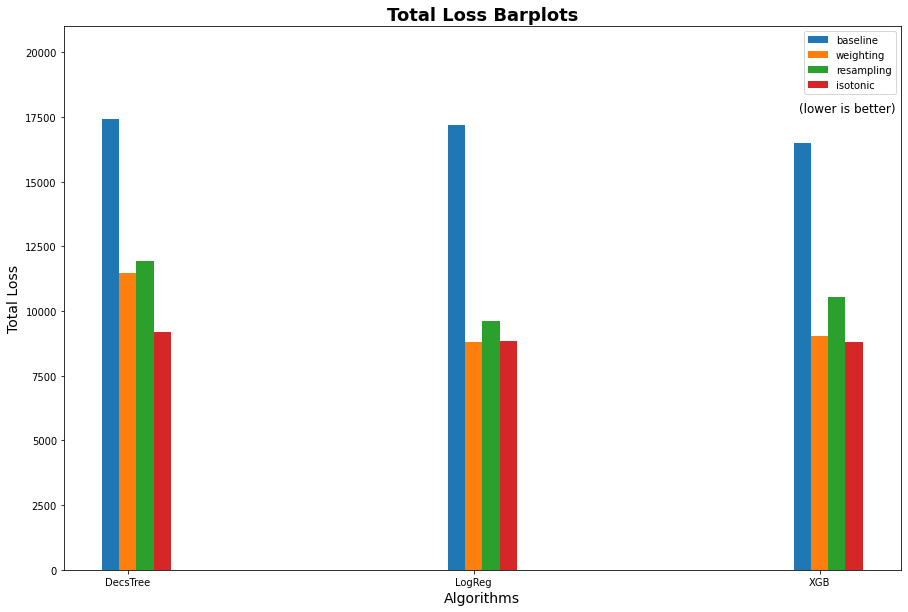

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))
N = 3
ind = np.arange(N) 
width = 0.05
  
bar1 = plt.bar(ind, baseline, width)
bar2 = plt.bar(ind + width, weight, width)
bar3 = plt.bar(ind + width * 2, comb, width)
bar4 = plt.bar(ind + width * 3, isot, width)

ax.set_title('Total Loss Barplots', fontsize = 18, fontweight = 'bold')  
plt.xlabel("Algorithms", fontsize = 14)
plt.ylabel('Total Loss', fontsize = 14)

plt.ylim((0,21000))  
ax.text(1.99, 17700, '(lower is better)', fontsize = 12, color='black')
  
plt.xticks(ind+width,['DecsTree', 'LogReg', 'XGB'])
plt.legend((bar1, bar2, bar3, bar4),
           ('baseline', 'weighting', 'resampling', 'isotonic'))
plt.show()

In [16]:
X_pool_og = X_pool
y_pool_pg = y_pool

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_pool = y_pool.to_numpy()

In [17]:
clf = LogisticRegression(class_weight = {0:1, 1:5}, solver = 'saga', max_iter = 1000, random_state = random_seed)

learner = ActiveLearner(estimator = clf, query_strategy = uncertainty_sampling, X_training = X_train, y_training = y_train)

In [18]:
num_of_queries = math.floor(len(X_pool) * 0.66)
print(f'Number of queries: {num_of_queries}')

print('Choosen instances: ', end = '', flush = True)
for index in range(num_of_queries):
    query_index, query_instance = learner.query(X_pool)
    print(query_index[0], end = ', ', flush = True)
    
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X, y)

    X_pool, y_pool = np.delete(X_pool, query_index, axis = 0), np.delete(y_pool, query_index, axis = 0)
    
print("\b\b\n\nActive Learner with Uncertainty Sampling (Logistic Regression)\n")
y_pred = learner.predict(X_test) 
print(classification_report(y_test, y_pred, target_names = ["Absence", "Presence"]))
conf_matrix = confusion_matrix(y_test, y_pred).T 
print(conf_matrix) 
total_loss = np.sum(conf_matrix * cost_matrix)
print(total_loss)

Number of queries: 1310
Choosen instances: 61, 73, 1514, 1514, 832, 377, 1708, 496, 1809, 68, 910, 202, 964, 1639, 789, 1398, 1863, 1613, 1015, 661, 631, 498, 1447, 1317, 601, 798, 882, 645, 973, 50, 1613, 1278, 952, 1459, 687, 826, 745, 1170, 606, 216, 1211, 1769, 1724, 1761, 1112, 1812, 377, 834, 1693, 622, 0, 1711, 1745, 756, 1669, 694, 30, 1408, 1288, 1701, 668, 1257, 977, 908, 1626, 795, 1673, 1809, 854, 1583, 988, 707, 786, 1523, 1222, 259, 1384, 1486, 1571, 1735, 1135, 1831, 1464, 355, 1260, 98, 1881, 4, 1507, 224, 529, 1134, 1492, 188, 1857, 735, 103, 1327, 1419, 1298, 105, 1742, 1551, 1737, 539, 699, 794, 138, 577, 981, 705, 1543, 448, 51, 1611, 1552, 1833, 699, 1512, 1822, 720, 1622, 1755, 1131, 1483, 203, 1525, 1047, 735, 467, 1452, 298, 23, 1473, 85, 523, 414, 1125, 1828, 1431, 1843, 1041, 894, 1195, 936, 1383, 824, 1382, 399, 980, 1392, 64, 1203, 884, 1004, 803, 1761, 1147, 56, 948, 1368, 965, 1378, 942, 1592, 1733, 310, 905, 1146, 162, 244, 979, 592, 1351, 182, 1569, 461,

In [19]:
model = Sequential()
model.add(Dense(19, input_dim = 19, activation = 'relu'))
model.add(Dense(50,activation = 'relu', kernel_initializer = tf.random_uniform_initializer(minval = -0.1, maxval = 0.1), bias_initializer = tf.random_uniform_initializer(minval = -0.1, maxval = 0.1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.001))

monitor = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 500, mode = 'min', restore_best_weights = True)

history = model.fit(X_train, y_train, class_weight = {0:1, 1:5}, validation_split = 0.25, epochs = 2000, callbacks = [monitor], verbose = 0)

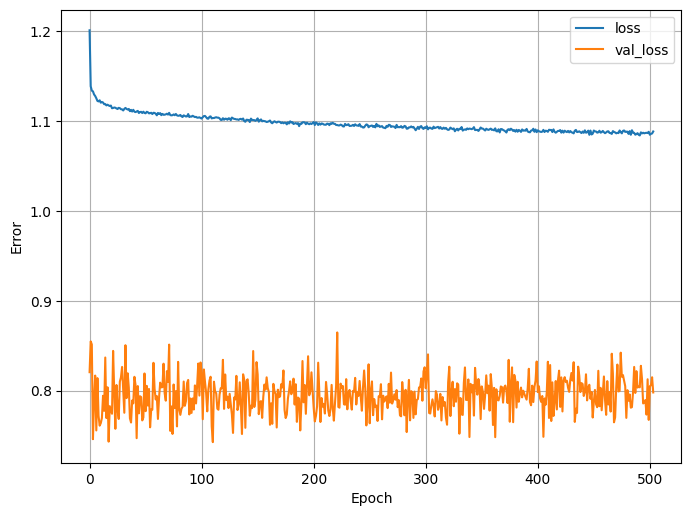

In [20]:
plt.figure(num = None, figsize = (8, 6), dpi = 100, facecolor = 'w', edgecolor = 'b')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [21]:
y_pred_nn = model.predict(X_test).round(decimals = 0)
print(classification_report(y_test, y_pred_nn, target_names = ["Absence", "Presence"]))
conf_matrix = confusion_matrix(y_test, y_pred_nn).T 
print(conf_matrix) 
total_loss = np.sum(conf_matrix * cost_matrix)
print(total_loss)

              precision    recall  f1-score   support

     Absence       0.87      0.23      0.36      9174
    Presence       0.54      0.96      0.69      8688

    accuracy                           0.58     17862
   macro avg       0.70      0.59      0.53     17862
weighted avg       0.71      0.58      0.52     17862

[[2077  320]
 [7097 8368]]
8697


Number of features: 19

Global White Model Performance:
Fidelity: 0.97
Accuracy in new data: 0.57


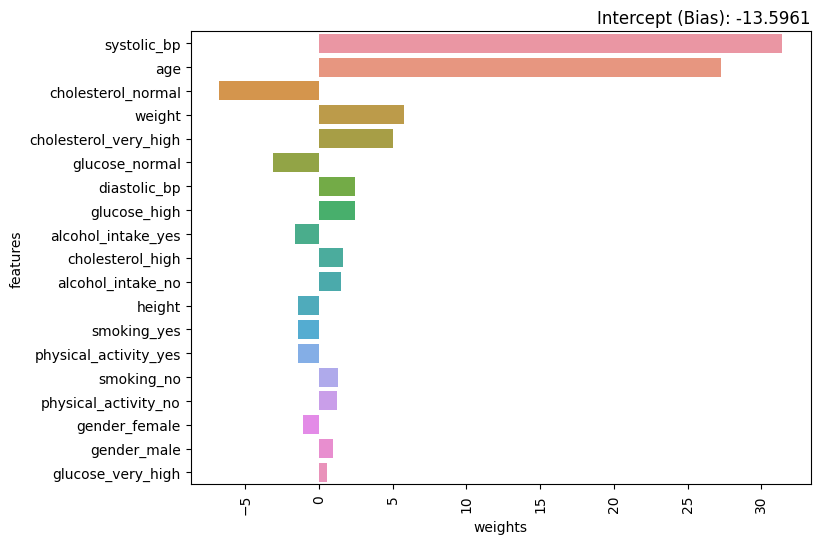

In [22]:
new_X_train = X_train
new_y_train = model.predict(X_train).round(decimals=0)

white_model = LogisticRegression(class_weight = {0:1, 1:5}, solver = 'saga', max_iter = 1000, random_state = random_seed)
white_model.fit(new_X_train, new_y_train)

white_model_predictions = white_model.predict(X_test)
white_model_probabilities = white_model.predict_proba

weights = white_model.coef_
model_weights = pd.DataFrame({ 'features': list(feature_names),'weights': list(weights[0])})
model_weights = model_weights.reindex(model_weights['weights'].abs().sort_values(ascending = False).index)
model_weights = model_weights[(model_weights["weights"] != 0)]    
print(f"Number of features: {len(model_weights.values)}")
print("\nGlobal White Model Performance:")

print(f"Fidelity: {accuracy_score(y_pred_nn, white_model_predictions):.2f}")
print(f"Accuracy in new data: {accuracy_score(y_test, white_model_predictions):.2f}")

plt.figure(num = None, figsize = (8, 6), dpi = 100, facecolor='w', edgecolor='b')
sns.barplot(x = "weights", y = "features", data = model_weights)
plt.title(f"Intercept (Bias): {white_model.intercept_[0]:.4f}", loc = 'right')
plt.xticks(rotation = 90)
plt.show()

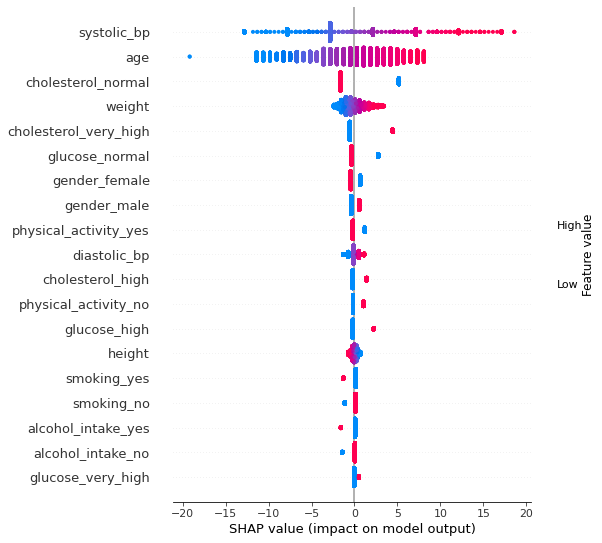

In [23]:
explainer = shap.LinearExplainer(white_model, X_train, feature_dependence = "independent")
shap.summary_plot(explainer.shap_values(X_test), X_test, feature_names = feature_names)

In [24]:
perm = PermutationImportance(white_model, random_state = random_seed).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = feature_names, top = 19)

In [25]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names = feature_names, class_names=["absence", "presence"],
                                                   categorical_features = categorical_features, categorical_names = category_names, 
                                                   kernel_width=3)


for i in range (5):
    instance = np.random.randint(0, X_test.shape[0])
    print(f"Instance {instance} explanation: \n")
    exp = explainer.explain_instance(X_test[instance], white_model_probabilities, num_features=5, top_labels=1)
    exp.show_in_notebook(show_table=True, show_all=True)

Instance 11417 explanation: 



Instance 1783 explanation: 



Instance 16849 explanation: 



Instance 5880 explanation: 



Instance 17371 explanation: 

